In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, BatchNormalization
%matplotlib inline

In [2]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices('GPU'))

Num GPUs Available:  1
True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## Data 

In [3]:
# Removing the simpsons_dataset folder from the trainings dataset

## Without Augmentation

In [4]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255, validation_split=0.2)

In [5]:
#train_dir = "D:\ML\simpsons\simpsons_dataset"
train_dir = "./data/simpsons_dataset/"
IMG_HEIGHT, IMG_WIDTH = 64, 64
batch_size = 8

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           subset='training',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           subset='validation',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 16764 images belonging to 42 classes.
Found 4169 images belonging to 42 classes.


In [6]:
num_classes = len(train_data_gen.class_indices)
num_steps = len(train_data_gen)
num_val_steps = len(val_data_gen)

In [6]:
print(num_steps)

2096


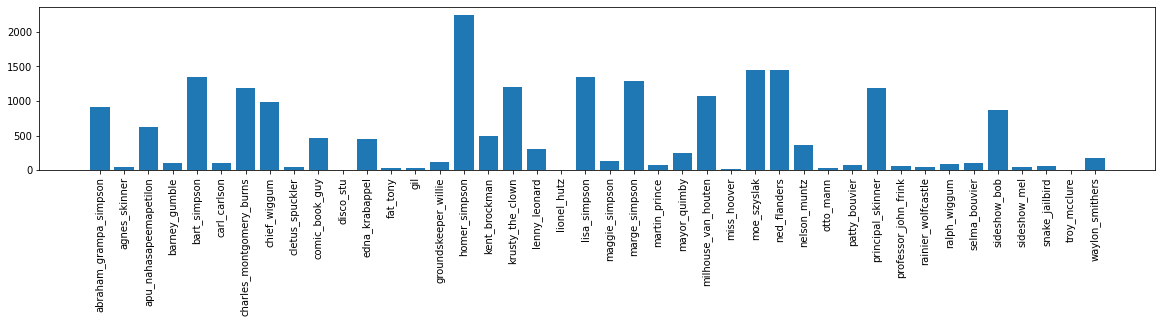

                    class  count
            homer_simpson   2246
             ned_flanders   1454
              moe_szyslak   1452
             lisa_simpson   1354
             bart_simpson   1342
            marge_simpson   1291
         krusty_the_clown   1206
        principal_skinner   1194
 charles_montgomery_burns   1193
      milhouse_van_houten   1079
             chief_wiggum    986
   abraham_grampa_simpson    913
             sideshow_bob    877
   apu_nahasapeemapetilon    623
            kent_brockman    498
           comic_book_guy    469
           edna_krabappel    457
             nelson_muntz    358
            lenny_leonard    310
             mayor_quimby    246
          waylon_smithers    181
           maggie_simpson    128
     groundskeeper_willie    121
            barney_gumble    106
            selma_bouvier    103
             carl_carlson     98
             ralph_wiggum     89
            patty_bouvier     72
            martin_prince     71
     profe

In [7]:
classnames=os.listdir(train_dir)
class_count_array = []
for d in classnames:
    class_count_array.append(len(os.listdir(os.path.join(train_dir, d))))
data = {'class': classnames, 'count': class_count_array}
data_dict = dict(zip(classnames, class_count_array))

plt.figure(figsize=(20, 3))
plt.bar(data_dict.keys(), data_dict.values())
plt.xticks(rotation='vertical')
plt.show()

df = pd.DataFrame(data).sort_values('count', ascending=False)
print(df.to_string(index=False))
#for k, v in class_count_dict.items():
#    print ( '%7s  %i' % (k, v))


In [9]:
print(len(train_data_gen.classes))

16764


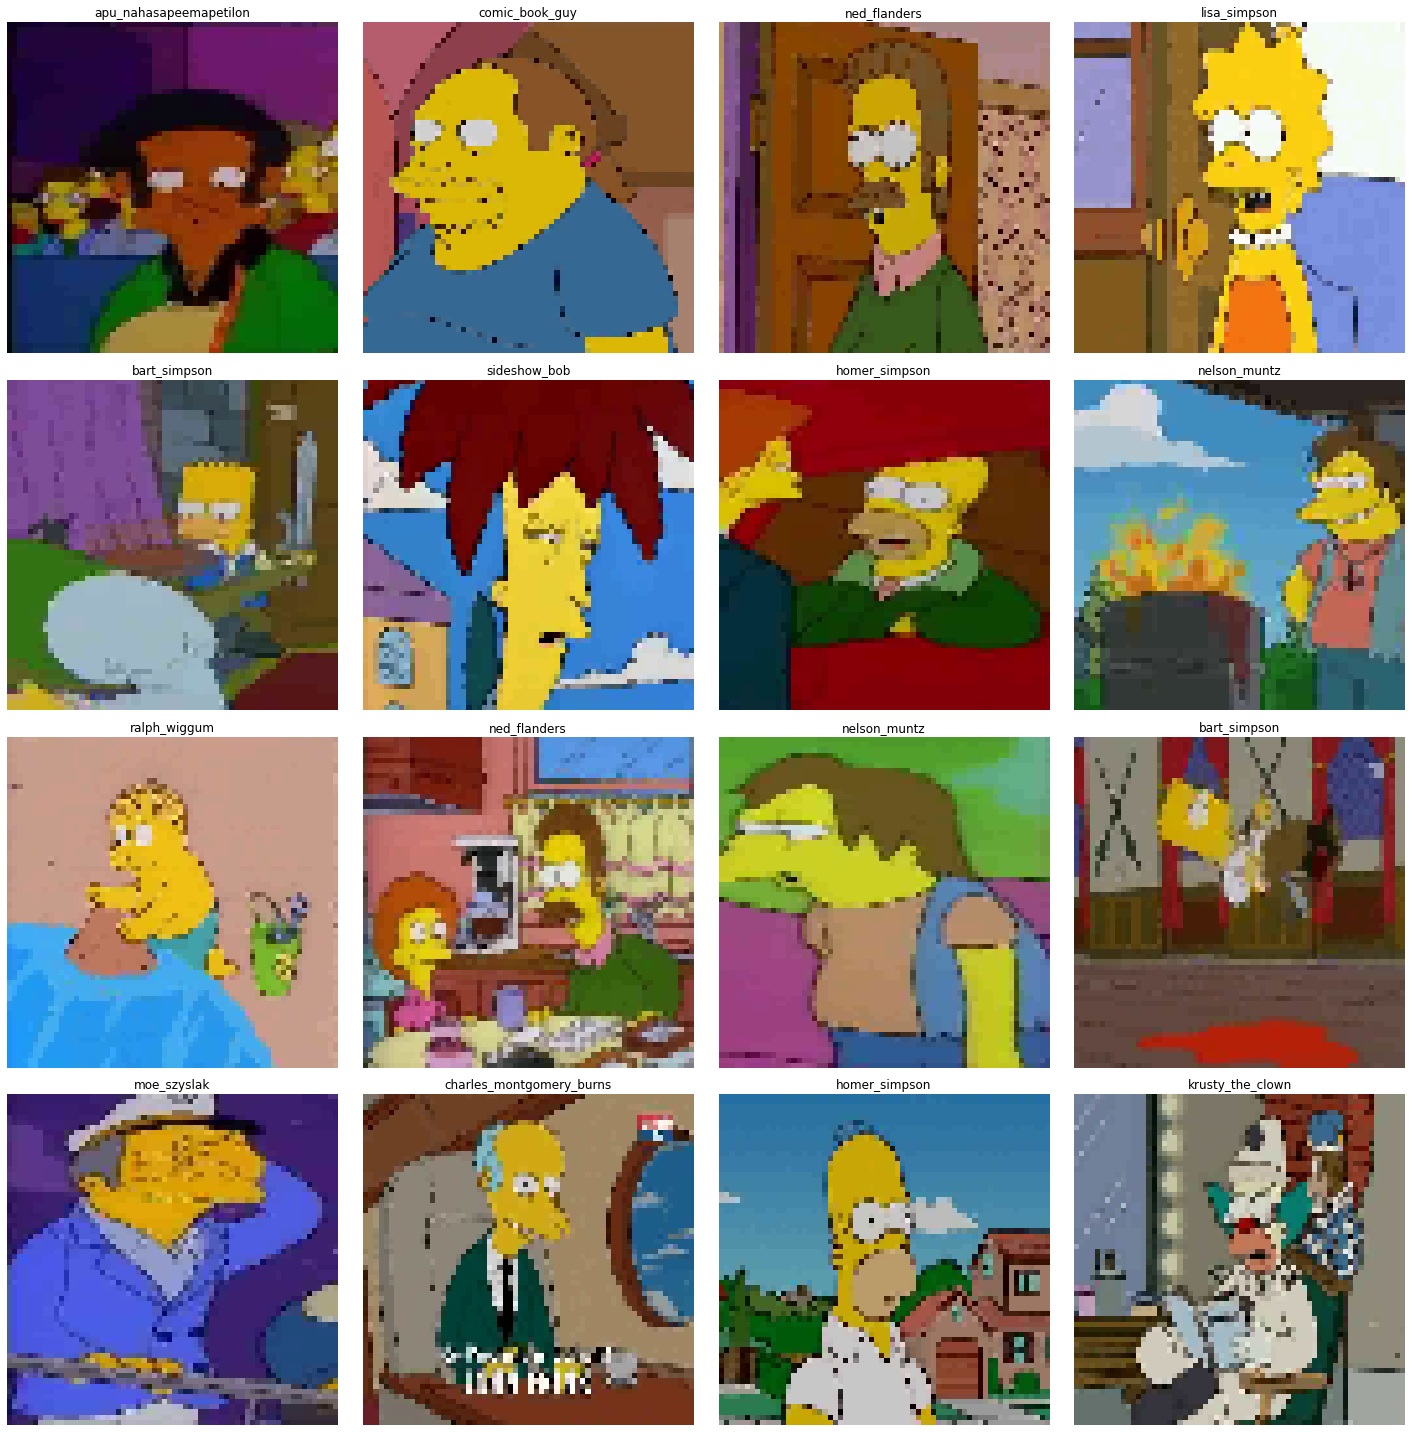

In [10]:
sample_training_images1, labels1 = next(train_data_gen)
sample_training_images2, labels2 = next(train_data_gen)
sample_training_images = np.concatenate((sample_training_images1, sample_training_images2), axis=0)
labels = np.concatenate((labels1, labels2), axis=0)
class_label = {v:k for k,v in train_data_gen.class_indices.items()}
fig, axes = plt.subplots(4, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

### Learning

In [11]:
def get_model(): 
    # Model https://www.kaggle.com/alexattia/characters-classification-using-keras
    model = Sequential()
    #model.add(tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
    model.add(Conv2D(32, (3, 3), padding='same', input_shape=(64,64,3)))
    # model.add(BatchNormalization()) # batch
    model.add(Activation('relu'))
    model.add(Conv2D(32, (3, 3)))
    #model.add(BatchNormalization()) # batch
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, (3, 3), padding='same'))
    # model.add(BatchNormalization()) # batch
    model.add(Activation('relu'))
    model.add(Conv2D(64, (3, 3)))
#     model.add(BatchNormalization()) # batch
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    #model.add(Dense(512))
    #model.add(Activation('relu'))
    #model.add(Dropout(0.5))
    model.add(Dense(num_classes))
    model.add(Activation('softmax'))
    return model

In [12]:
model = get_model()
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [13]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 64, 64, 32)        896       
_________________________________________________________________
activation (Activation)      (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 62, 62, 32)        9248      
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 32)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 31, 31, 64)        1

In [14]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots",
    verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, verbose=0, mode='max')

ACCURACY_THRESHOLD = 0.90
class accCallback(tf.keras.callbacks.Callback): 
    def on_epoch_end(self, epoch, logs={}): 
        if(logs.get('accuracy') > ACCURACY_THRESHOLD):   
            print("\nReached %2.2f%% accuracy, so stopping training!!" %(ACCURACY_THRESHOLD*100))   
            self.model.stop_training = True
        
acc_callback = accCallback()


In [15]:
history = model.fit(train_data_gen, 
                    steps_per_epoch=500, # num_steps
                    validation_data=val_data_gen,
                    validation_steps=200, # num_val_steps
                    epochs=100,
                    callbacks=[snapshot_callback, early_stopping]) # use early stopping
model.save('model1')

Epoch 1/100
497/500 [============================>.] - ETA: 0s - loss: 2.9320 - accuracy: 0.1836
Epoch 00001: saving model to .\snapshots
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: .\snapshots\assets
500/500 [==============================] - 8s 16ms/step - loss: 2.9323 - accuracy: 0.1835 - val_loss: 2.7577 - val_accuracy: 0.2650
Epoch 2/100
498/500 [============================>.] - ETA: 0s - loss: 2.2868 - accuracy: 0.3863
Epoch 00002: saving model to .\snapshots
INFO:tensorflow:Assets written to: .\snapshots\assets
500/500 [==============================] - 8s 15ms/step - loss: 2.2879 - accuracy: 0.3855 - val_loss: 2.2434 - val_accuracy: 0.4112
Epoch 3/100
498/500 [============================>.] - ETA: 0s - loss: 1.8681 - accuracy: 0.4912
Epoch 00003: saving m

In [16]:
def plot_history_loss(history): 
    plt.figure(figsize=(15,7))
    plt.plot(history.history['loss'], '--', label="loss")
    plt.plot(history.history['val_loss'], '--', label="val_loss")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
def plot_history_acc(history): 
    plt.figure(figsize=(15,7))
    plt.plot(history.history['accuracy'], '--', label="accuracy")
    plt.plot(history.history['val_accuracy'], '--', label="val_accuracy")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()
def plot_history(history):
    plt.figure(figsize=(15,7))
    plt.plot(history.history['loss'], '--', label="loss")
    plt.plot(history.history['val_loss'], '--', label="val_loss")
    plt.plot(history.history['accuracy'], '-', label="accuracy")
    plt.plot(history.history['val_accuracy'], '-', label="val_accuracy")
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend()

In [ ]:
plot_history_loss(history)
plot_history_acc(history)
plot_history(history)

In [ ]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots2",
    verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs2")
model2 = get_model()
model2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(train_data_gen, 
                    steps_per_epoch=500, # num_steps
                    validation_data=val_data_gen,
                    validation_steps=200, # num_val_steps
                    epochs=100,
                    callbacks=[snapshot_callback, early_stopping]) # use early stopping
model2.save('model2')

In [ ]:
plot_history_loss(history2)
plot_history_acc(history2)
plot_history(history2)

## With Data Augmentation

In [ ]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                        validation_split=0.2,
                                                                        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
                                                                        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                                                        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                                                        horizontal_flip=True,  # randomly flip images
                                                                        vertical_flip=False)

In [ ]:
train_dir = "D:\ML\simpsons\simpsons_dataset"
IMG_HEIGHT, IMG_WIDTH = 64, 64
batch_size = 8

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           subset='training',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           subset='validation',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

In [ ]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots3",
    verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs3")

model3 = get_model()
model3.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history3 = model3.fit(train_data_gen, 
                    steps_per_epoch=500, # num_steps
                    validation_data=val_data_gen,
                    validation_steps=200, # num_val_steps
                    epochs=100,
                    callbacks=[snapshot_callback, early_stopping]) # use early stopping
model.save('model3')

In [ ]:
plot_history_loss(history3)
plot_history_acc(history3)
plot_history(history3)

In [ ]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots4",
    verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs4")

model4 = get_model()
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history4 = model4.fit(train_data_gen, 
                    steps_per_epoch=500, # num_steps
                    validation_data=val_data_gen,
                    validation_steps=200, # num_val_steps
                    epochs=100,
                    callbacks=[snapshot_callback, early_stopping]) # use early stopping
model4.save('model4')

In [ ]:
plot_history_loss(history4)
plot_history_acc(history4)
plot_history(history4)

# Results

In [ ]:
# x_test, y_test = load_test_set("D:\\ML\\simpsons\\kaggle_simpson_testset\\kaggle_simpson_testset\\")

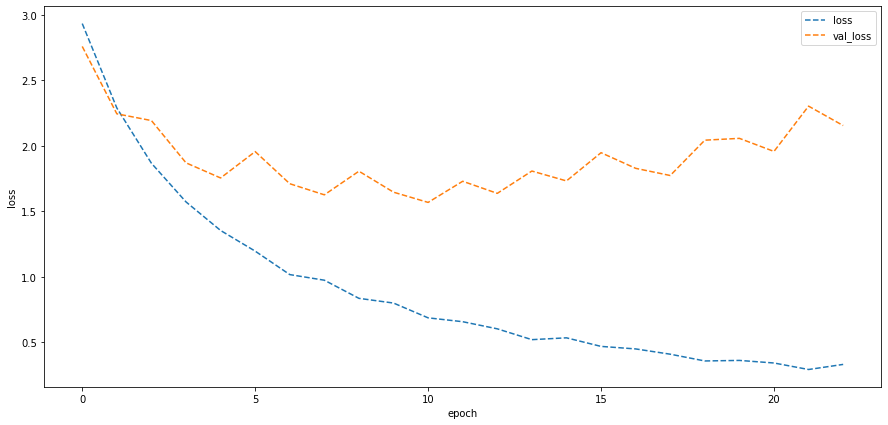

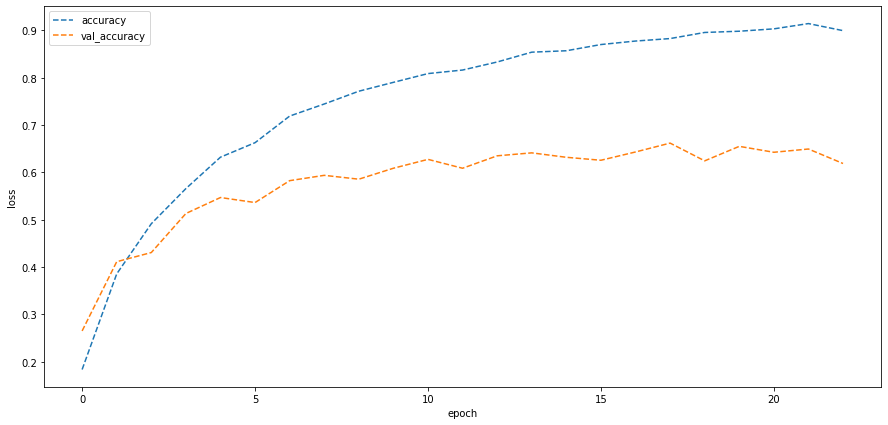

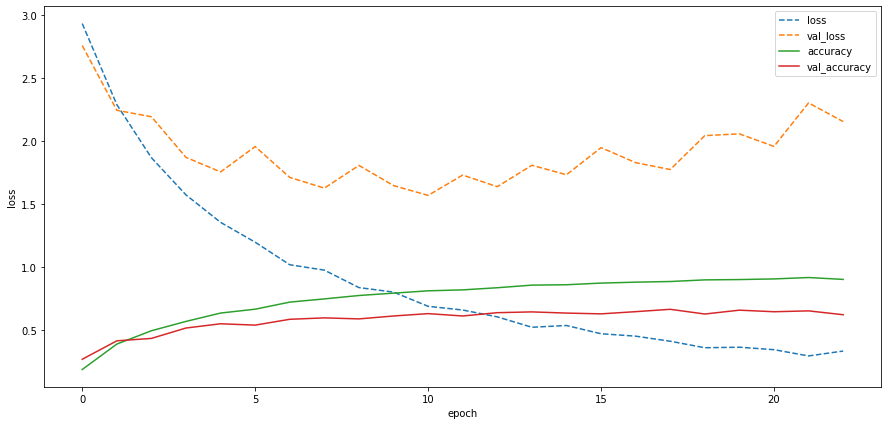

In [17]:
# x_test, y_test = load_test_set("D:\\ML\\simpsons\\kaggle_simpson_testset\\kaggle_simpson_testset\\")

In [18]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots2",
    verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs2")
model2 = get_model()
model2.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history2 = model2.fit(train_data_gen, 
                    steps_per_epoch=500, # num_steps
                    validation_data=val_data_gen,
                    validation_steps=200, # num_val_steps
                    epochs=100,
                    callbacks=[snapshot_callback, early_stopping]) # use early stopping
model2.save('model2')

Epoch 1/100
496/500 [============================>.] - ETA: 0s - loss: 3.0544 - accuracy: 0.1333
Epoch 00001: saving model to .\snapshots2
INFO:tensorflow:Assets written to: .\snapshots2\assets
500/500 [==============================] - 7s 15ms/step - loss: 3.0550 - accuracy: 0.1340 - val_loss: 2.9744 - val_accuracy: 0.1737
Epoch 2/100
499/500 [============================>.] - ETA: 0s - loss: 2.8132 - accuracy: 0.2352
Epoch 00002: saving model to .\snapshots2
INFO:tensorflow:Assets written to: .\snapshots2\assets
500/500 [==============================] - 7s 15ms/step - loss: 2.8134 - accuracy: 0.2352 - val_loss: 2.7636 - val_accuracy: 0.2525
Epoch 3/100
499/500 [============================>.] - ETA: 0s - loss: 2.7422 - accuracy: 0.2728
Epoch 00003: saving model to .\snapshots2
INFO:tensorflow:Assets written to: .\snapshots2\assets
500/500 [==============================] - 7s 15ms/step - loss: 2.7420 - accuracy: 0.2730 - val_loss: 2.8058 - val_accuracy: 0.2463
Epoch 4/100
498/500 [=

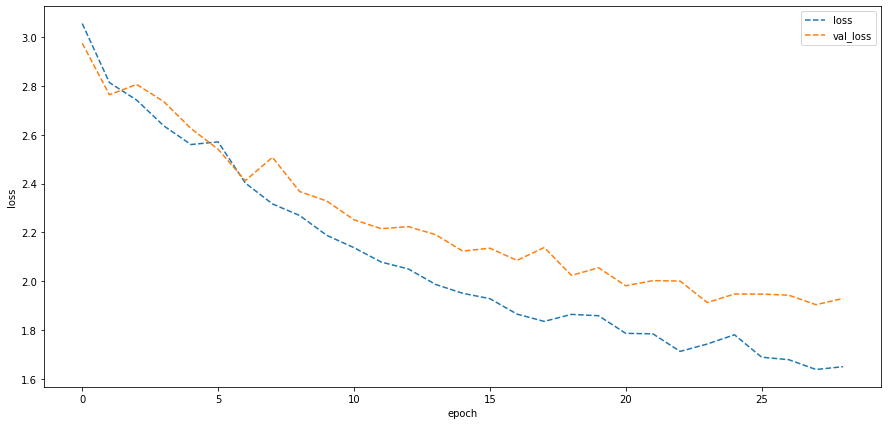

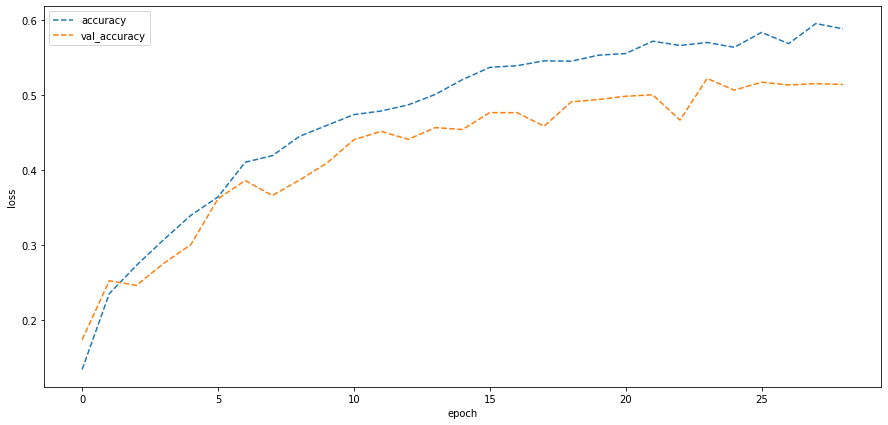

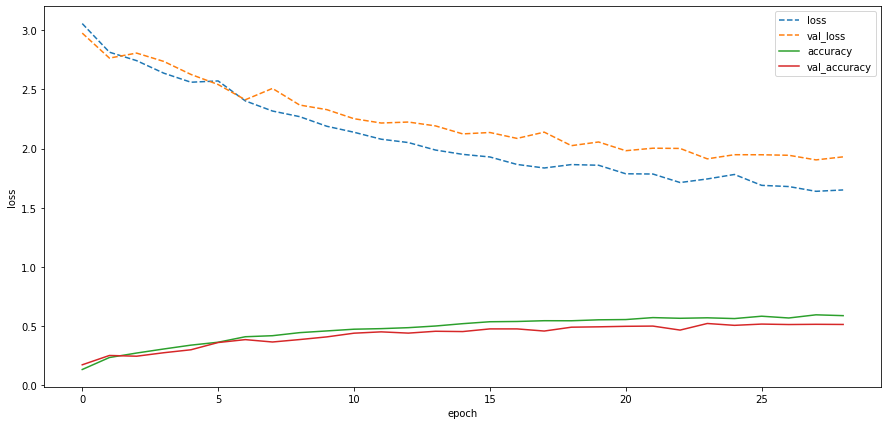

In [19]:
plot_history_loss(history2)
plot_history_acc(history2)
plot_history(history2)

## With Data Augmentation

In [20]:
train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                        validation_split=0.2,
                                                                        rotation_range=15,  # randomly rotate images in the range (degrees, 0 to 180)
                                                                        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
                                                                        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
                                                                        horizontal_flip=True,  # randomly flip images
                                                                        vertical_flip=False)

In [21]:
train_dir = "D:\ML\simpsons\simpsons_dataset"
IMG_HEIGHT, IMG_WIDTH = 64, 64
batch_size = 8

train_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           subset='training',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

val_data_gen = train_image_generator.flow_from_directory(batch_size=batch_size,
                                                           directory=train_dir,
                                                           subset='validation',
                                                           shuffle=True,
                                                           target_size=(IMG_HEIGHT, IMG_WIDTH))

Found 16764 images belonging to 42 classes.
Found 4169 images belonging to 42 classes.


In [22]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots3",
    verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs3")

model3 = get_model()
model3.compile(optimizer=tf.keras.optimizers.RMSprop(lr=0.0001, decay=1e-6),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history3 = model3.fit(train_data_gen, 
                    steps_per_epoch=500, # num_steps
                    validation_data=val_data_gen,
                    validation_steps=200, # num_val_steps
                    epochs=100,
                    callbacks=[snapshot_callback, early_stopping]) # use early stopping
model.save('model3')

Epoch 1/100
499/500 [============================>.] - ETA: 0s - loss: 3.1120 - accuracy: 0.1155
Epoch 00001: saving model to .\snapshots3
INFO:tensorflow:Assets written to: .\snapshots3\assets
500/500 [==============================] - 13s 26ms/step - loss: 3.1107 - accuracy: 0.1163 - val_loss: 2.9695 - val_accuracy: 0.1656
Epoch 2/100
498/500 [============================>.] - ETA: 0s - loss: 2.8663 - accuracy: 0.2038
Epoch 00002: saving model to .\snapshots3
INFO:tensorflow:Assets written to: .\snapshots3\assets
500/500 [==============================] - 13s 26ms/step - loss: 2.8655 - accuracy: 0.2037 - val_loss: 2.8324 - val_accuracy: 0.2156
Epoch 3/100
499/500 [============================>.] - ETA: 0s - loss: 2.7694 - accuracy: 0.2518
Epoch 00003: saving model to .\snapshots3
INFO:tensorflow:Assets written to: .\snapshots3\assets
500/500 [==============================] - 13s 25ms/step - loss: 2.7695 - accuracy: 0.2515 - val_loss: 2.7297 - val_accuracy: 0.2675
Epoch 4/100
497/500

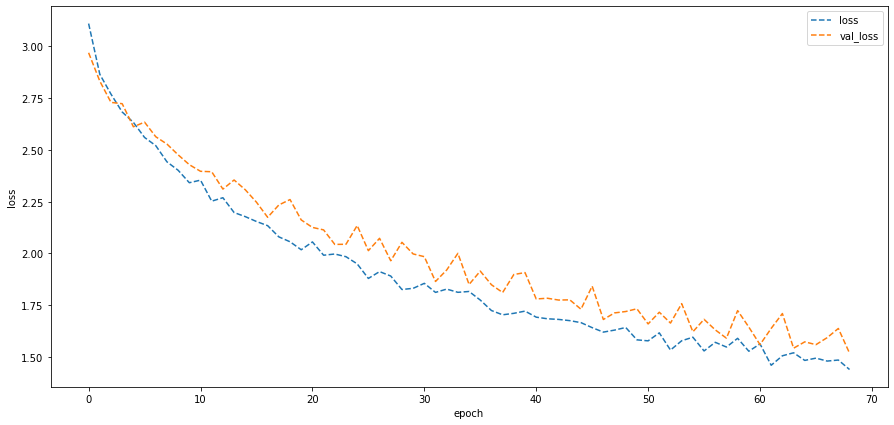

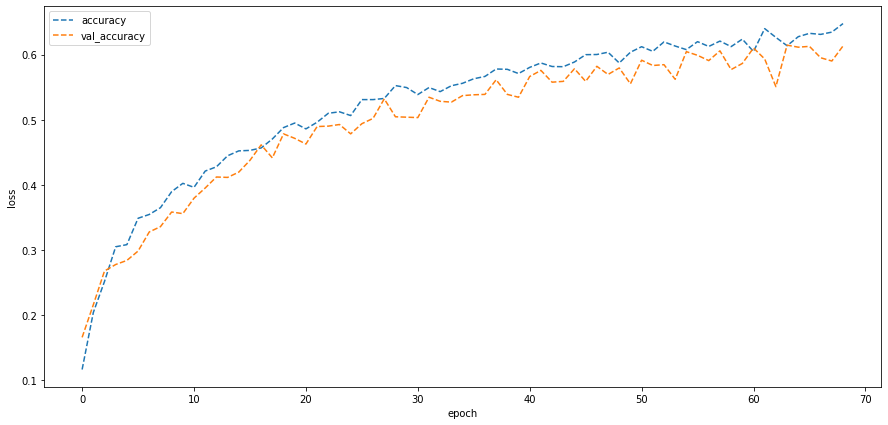

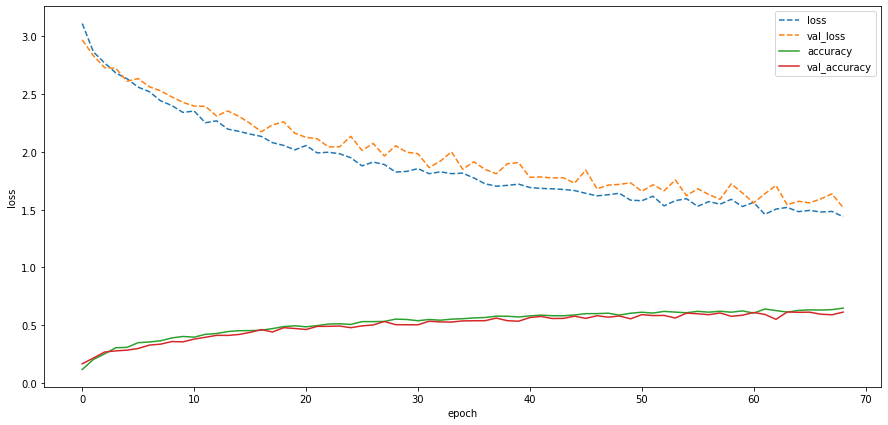

In [23]:
plot_history_loss(history3)
plot_history_acc(history3)
plot_history(history3)

In [24]:
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots4",
    verbose=1)

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs4")

model4 = get_model()
model4.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
history4 = model4.fit(train_data_gen, 
                    steps_per_epoch=500, # num_steps
                    validation_data=val_data_gen,
                    validation_steps=200, # num_val_steps
                    epochs=100,
                    callbacks=[snapshot_callback, early_stopping]) # use early stopping
model4.save('model4')

Epoch 1/100
500/500 [==============================] - ETA: 0s - loss: 2.9059 - accuracy: 0.1875
Epoch 00001: saving model to .\snapshots4
INFO:tensorflow:Assets written to: .\snapshots4\assets
500/500 [==============================] - 13s 26ms/step - loss: 2.9059 - accuracy: 0.1875 - val_loss: 2.7007 - val_accuracy: 0.2500
Epoch 2/100
498/500 [============================>.] - ETA: 0s - loss: 2.4551 - accuracy: 0.3386
Epoch 00002: saving model to .\snapshots4
INFO:tensorflow:Assets written to: .\snapshots4\assets
500/500 [==============================] - 13s 26ms/step - loss: 2.4564 - accuracy: 0.3383 - val_loss: 2.3280 - val_accuracy: 0.3894
Epoch 3/100
499/500 [============================>.] - ETA: 0s - loss: 2.1911 - accuracy: 0.4153
Epoch 00003: saving model to .\snapshots4
INFO:tensorflow:Assets written to: .\snapshots4\assets
500/500 [==============================] - 13s 26ms/step - loss: 2.1896 - accuracy: 0.4157 - val_loss: 2.1741 - val_accuracy: 0.4363
Epoch 4/100
500/500

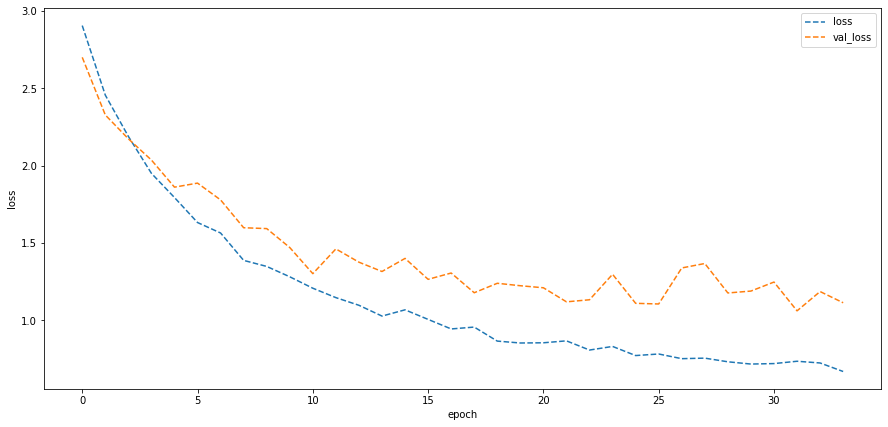

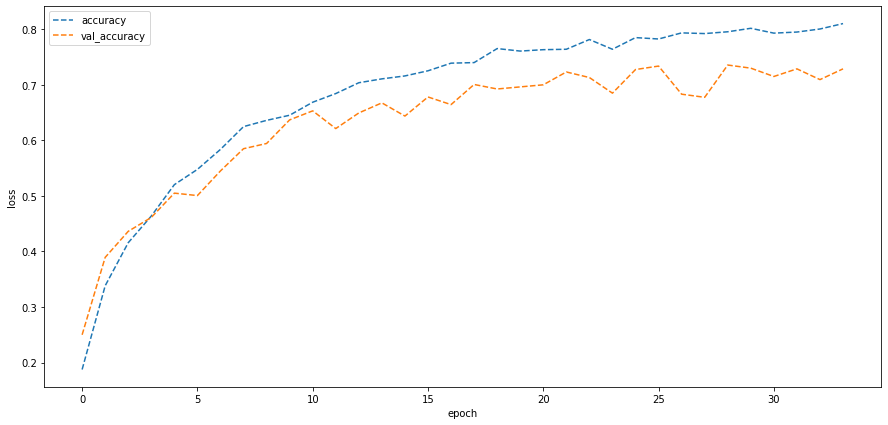

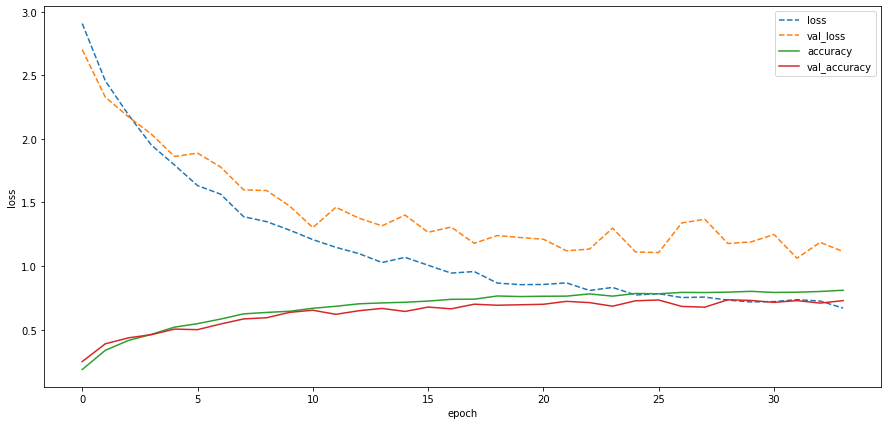

In [25]:
plot_history_loss(history4)
plot_history_acc(history4)
plot_history(history4)

# Results

In [23]:
import glob
import sklearn
from sklearn.metrics import confusion_matrix

def load_test_set(path):
    pics, labels = [], []
    reverse_dict = train_data_gen.class_indices
    for pic in glob.glob(path+'*.*'):
        char_name = "_".join(pic.split('\\')[4].split('_')[:-1])
        if char_name in reverse_dict:
            temp = cv2.imread(pic)
            temp = cv2.resize(temp, (64,64)).astype('float32') / 255.
            temp = temp[...,::-1]
            pics.append(temp)
            labels.append(reverse_dict[char_name])
    X_test = np.array(pics)
    y_test = np.array(labels)
    y_test = tf.keras.utils.to_categorical(y_test, num_classes)
    print("Test set", X_test.shape, y_test.shape)
    return X_test, y_test

X_test, y_test = load_test_set(".\\data\\kaggle_simpson_testset\\kaggle_simpson_testset\\")

Test set (990, 64, 64, 3) (990, 42)


In [8]:
def stats_every_character(y_pred, y_test):
    report = []
    true_pos_tot = 0
    names = []
    space_max = np.max([len(name) for name in train_data_gen.class_indices.keys()])
    report.append('{s}{space}{s2}{space2}{s3}'.format(s='character', 
                                          space= ' ' * (space_max + 2 - len("character")), 
                                          s2='Precision',
                                          space2= '  ', 
                                          s3='Support'))
    for name, id_char in train_data_gen.class_indices.items():
        idx_char = [i for i, x in enumerate(np.argmax(y_pred, axis= 1) == id_char) if x]
        true_pos = np.sum(np.argmax(y_test[idx_char], axis=1) == np.argmax(y_pred[idx_char], axis=1))
        if(len(idx_char) == 0):
            continue
        true_pos_tot += true_pos
        names.append(name.replace('_',' ').title())
        report.append('{s}{space}{f:.2f}{space2}{s3}'.format(s=name.replace('_',' ').title(), 
                                                             space= ' ' * (space_max + 4 - len(name)), 
                                                             f=true_pos/len(idx_char),
                                                             space2 = ' '*6,
                                                             s3 = len(idx_char)))
    report.append('{s}{space}{f:.2f}{space2}{s3}'.format(s="Total", 
                                             space= ' ' * (space_max + 4 - len('Total')), 
                                             f=true_pos_tot/len(y_test),
                                             space2 = ' '*6,
                                             s3 = len(y_pred)))

    #names.append("Total")
    return report, names

## Model Adam

In [21]:
predict_model = tf.keras.models.load_model('adam')
y_pred = predict_model.predict(X_test)
report, names = stats_every_character(y_pred, y_test)

In [17]:
# Report vom kaggle notebook guy
# print('\n'.join(report))

In [22]:
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=names))


                           precision    recall  f1-score   support

  Abraham Grampa Simpson       0.93      0.81      0.87        48
  Apu Nahasapeemapetilon       0.92      0.90      0.91        50
            Bart Simpson       0.85      0.82      0.84        50
            Carl Carlson       0.00      0.00      0.00         0
Charles Montgomery Burns       0.78      0.83      0.81        48
            Chief Wiggum       0.90      0.92      0.91        50
          Comic Book Guy       1.00      0.92      0.96        49
          Edna Krabappel       0.98      0.84      0.90        50
           Homer Simpson       0.62      0.94      0.75        50
           Kent Brockman       0.91      0.84      0.87        50
        Krusty The Clown       0.98      0.88      0.93        50
           Lenny Leonard       1.00      0.88      0.94        50
            Lisa Simpson       0.81      0.78      0.80        50
           Marge Simpson       0.88      0.98      0.92        50
       

## model1

In [11]:
predict_model = tf.keras.models.load_model('model1')
y_pred = predict_model.predict(X_test)
report, names = stats_every_character(y_pred, y_test)

In [ ]:
# Report vom kaggle notebook guy
# print('\n'.join(report))

In [13]:
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=names))


                           precision    recall  f1-score   support

  Abraham Grampa Simpson       0.97      0.62      0.76        48
  Apu Nahasapeemapetilon       0.92      0.92      0.92        50
           Barney Gumble       0.00      0.00      0.00         0
            Bart Simpson       0.77      0.92      0.84        50
Charles Montgomery Burns       0.67      0.85      0.75        48
            Chief Wiggum       0.96      0.88      0.92        50
          Comic Book Guy       0.94      0.90      0.92        49
          Edna Krabappel       0.95      0.80      0.87        50
    Groundskeeper Willie       0.00      0.00      0.00         0
           Homer Simpson       0.63      0.92      0.75        50
           Kent Brockman       0.95      0.80      0.87        50
        Krusty The Clown       0.94      0.94      0.94        50
           Lenny Leonard       0.97      0.78      0.87        50
            Lisa Simpson       1.00      0.74      0.85        50
       

## model2

In [14]:
predict_model = tf.keras.models.load_model('model2')
y_pred = predict_model.predict(X_test)
report, names = stats_every_character(y_pred, y_test)

In [ ]:
# Report vom kaggle notebook guy
# print('\n'.join(report))

In [15]:
# ka warum bei model2 die anzahl der klassen wieder ned stimmt

print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=names))

ValueError: Number of classes, 20, does not match size of target_names, 19. Try specifying the labels parameter

## model3

In [16]:
predict_model = tf.keras.models.load_model('model3')
y_pred = predict_model.predict(X_test)
report, names = stats_every_character(y_pred, y_test)

In [ ]:
# Report vom kaggle notebook guy
# print('\n'.join(report))

In [17]:
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=names))


                           precision    recall  f1-score   support

  Abraham Grampa Simpson       0.97      0.62      0.76        48
  Apu Nahasapeemapetilon       0.92      0.92      0.92        50
           Barney Gumble       0.00      0.00      0.00         0
            Bart Simpson       0.77      0.92      0.84        50
Charles Montgomery Burns       0.67      0.85      0.75        48
            Chief Wiggum       0.96      0.88      0.92        50
          Comic Book Guy       0.94      0.90      0.92        49
          Edna Krabappel       0.95      0.80      0.87        50
    Groundskeeper Willie       0.00      0.00      0.00         0
           Homer Simpson       0.63      0.92      0.75        50
           Kent Brockman       0.95      0.80      0.87        50
        Krusty The Clown       0.94      0.94      0.94        50
           Lenny Leonard       0.97      0.78      0.87        50
            Lisa Simpson       1.00      0.74      0.85        50
       

## model4

In [18]:
predict_model = tf.keras.models.load_model('model4')
y_pred = predict_model.predict(X_test)
report, names = stats_every_character(y_pred, y_test)

In [ ]:
# Report vom kaggle notebook guy
# print('\n'.join(report))

In [19]:
print('\n', sklearn.metrics.classification_report(np.where(y_test > 0)[1], 
                                                  np.argmax(y_pred, axis=1), 
                                                  target_names=names))


                           precision    recall  f1-score   support

  Abraham Grampa Simpson       0.94      0.65      0.77        48
           Agnes Skinner       0.00      0.00      0.00         0
  Apu Nahasapeemapetilon       0.98      0.88      0.93        50
            Bart Simpson       0.87      0.78      0.82        50
            Carl Carlson       0.00      0.00      0.00         0
Charles Montgomery Burns       0.74      0.83      0.78        48
            Chief Wiggum       0.87      0.94      0.90        50
         Cletus Spuckler       0.00      0.00      0.00         0
          Comic Book Guy       0.95      0.71      0.81        49
          Edna Krabappel       0.93      0.82      0.87        50
    Groundskeeper Willie       0.00      0.00      0.00         0
           Homer Simpson       0.68      0.88      0.77        50
           Kent Brockman       0.95      0.84      0.89        50
        Krusty The Clown       0.86      0.98      0.92        50
       